# Uploading Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor

import numpy as np
from sklearn.impute import KNNImputer as imputer

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV # Setup

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error as MAE

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from catboost import CatBoostRegressor

# Exploratory Data Analysis

## Loading Datasets

In [ ]:
dev = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dsl_septembercall/development.tsv", sep='\t', parse_dates=True) #development
eval = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dsl_septembercall/evaluation.tsv", sep='\t') #evaluation

## Identify IQ

In [ ]:
X_iq = dev[dev['city']=='iq']
X_iq_nz = X_iq[X_iq['week_start_date']>='2001-11-19']

## Plotting Data evaluation

In [ ]:
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
dummy = X_iq[['year','week_start_date','total_cases','max_temp_c', 'avg_temp_c', 'min_temp_c']]
dummy['week_start_date'] = pd.to_datetime(dummy['week_start_date'], errors='coerce')
#groups = dummy.groupby(Grouper(freq='A'))

(array([730120., 730486., 730851., 731216., 731581., 731947., 732312.,
        732677., 733042.]), <a list of 9 Text major ticklabel objects>)

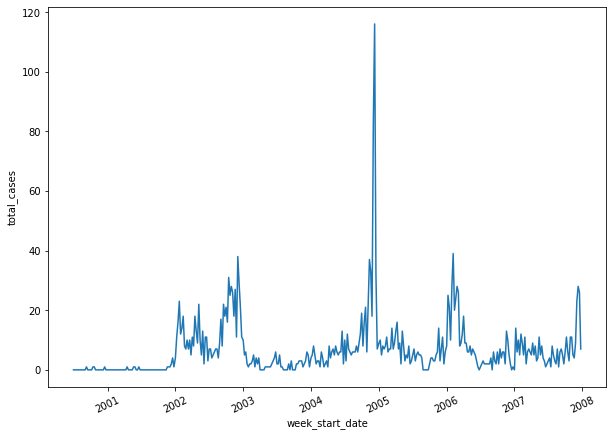

In [ ]:
plt.figure(figsize=(10, 7))

sns.lineplot(x = "week_start_date", y = "total_cases", data = dummy[['week_start_date','total_cases']],palette='Set2')  
plt.xticks(rotation = 25)

(array([730120., 730486., 730851., 731216., 731581., 731947., 732312.,
        732677., 733042.]), <a list of 9 Text major ticklabel objects>)

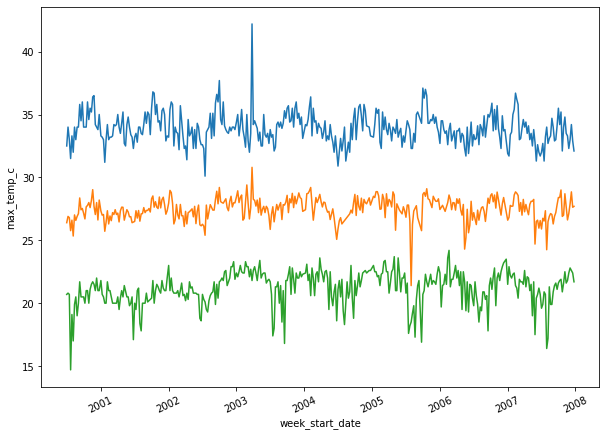

In [ ]:
plt.figure(figsize=(10, 7))

sns.lineplot(x = "week_start_date", y = "max_temp_c", data = dummy[['week_start_date','max_temp_c']],markers=True, dashes=False, legend=True)  
sns.lineplot(x = "week_start_date", y = "avg_temp_c", data = dummy[['week_start_date','avg_temp_c']],markers=True, dashes=False, legend=True)  
sns.lineplot(x = "week_start_date", y = "min_temp_c", data = dummy[['week_start_date','min_temp_c']],markers=True, dashes=False, legend=True)  
plt.xticks(rotation = 25)

#Preprocessing

## Processing NaNs and Outliers

In [ ]:
dev = dev.drop(columns=["year"])
eval = eval.drop(columns=["year", 'week_start_date'])

In [ ]:
X_iq = dev[dev['city']=='iq']
X_iq_nz = X_iq[X_iq['week_start_date']>='2001-11-19']

In [ ]:
X_iq_nz = X_iq_nz.drop(columns=['week_start_date'])
X_iq = X_iq.drop(columns=['week_start_date'])

In [ ]:
X_iq_nz = X_iq_nz[X_iq_nz['max_temp_c']<40]

In [ ]:
X_iq = X_iq.dropna(thresh=5)
X_iq_nz = X_iq_nz.dropna(thresh=5)
nanKNN = imputer(n_neighbors=5)#, weights= 'distance')

y_train = X_iq["total_cases"]
y_train_nz = X_iq_nz["total_cases"]

X_train = X_iq.drop(columns=['total_cases', 'city'])
X_train_nz = X_iq_nz.drop(columns=['total_cases', 'city'])
X_eval = eval.drop(columns='city')

for col in X_train.columns:
  #X_train[col] = nanKNN.fit_transform(X_train[col].values.reshape(-1,1))
  X_train_nz[col] = nanKNN.fit_transform(X_train_nz[col].values.reshape(-1,1))
  X_eval[col] = nanKNN.transform(X_eval[col].values.reshape(-1,1))

##Evaluating Correlation

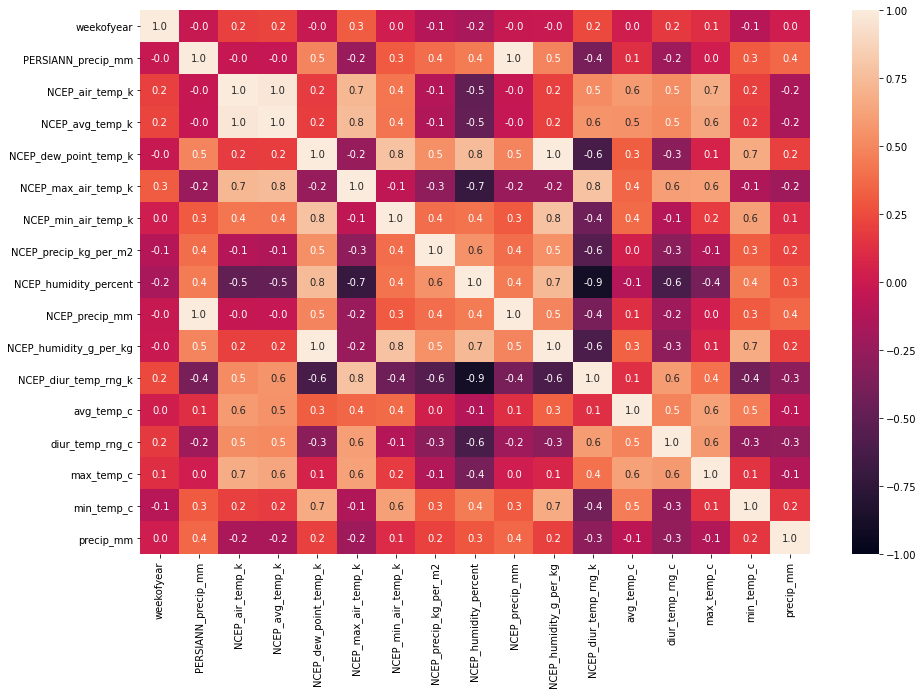

In [ ]:
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(X_train_nz.corr(), vmin=-1, vmax=1, annot=True, fmt='.1f')

### Dropping High correlated columns

In [ ]:
def toDropCols(df, thresh):
  cor_matrix = df.corr().abs()
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
  to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= thresh)]
  
  return to_drop

to_drop = toDropCols(X_iq, 0.85)

drop = True

if drop:
  X_train = X_train.drop(columns=to_drop, axis=1)
  X_train_nz = X_train_nz.drop(columns=to_drop, axis=1)
  X_eval = X_eval.drop(columns=to_drop, axis=1)

### Plotting remaning columns

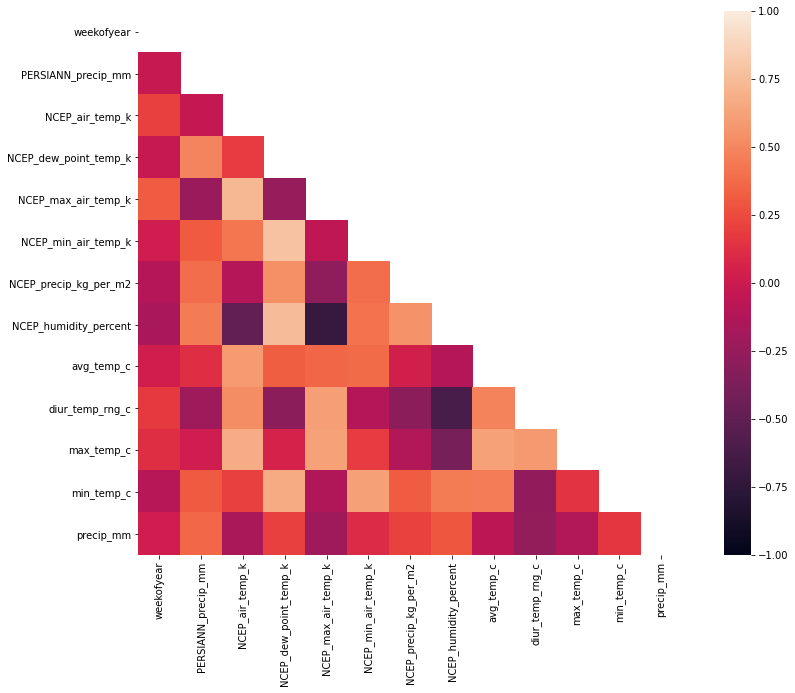

In [ ]:
plt.figure(figsize=(15, 10))
matrix = np.triu(X_train_nz.corr())
heatmap = sns.heatmap(X_train_nz.corr(), vmin=-1, vmax=1, annot=False, square=True, mask=matrix)

Text(0.5, 1.0, 'Correlations for Iquitos total cases')

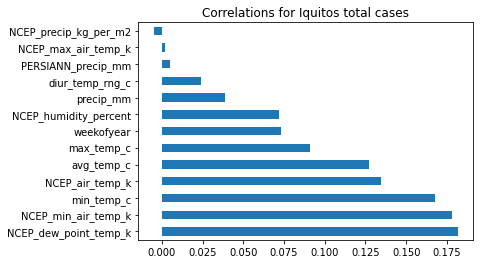

In [ ]:
X_dummy = pd.concat([X_train_nz, y_train_nz], axis=1)
correlations = X_dummy.corr()
correlations['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh()
plt.title('Correlations for Iquitos total cases')



#Training 

## Preparing input data

In [ ]:
y_overlap = dev['total_cases'].iloc[286:390]
X_eval_overlap = X_eval.loc[130:233] 
y_overlap.index = X_eval_overlap.index
X_eval_no_overlap = X_eval.loc[X_eval.index.difference(X_eval_overlap.index)]

In [ ]:
X_eval_no_overlap.head()

,weekofyear,PERSIANN_precip_mm,NCEP_air_temp_k,NCEP_dew_point_temp_k,NCEP_max_air_temp_k,NCEP_min_air_temp_k,NCEP_precip_kg_per_m2,NCEP_humidity_percent,avg_temp_c,diur_temp_rng_c,max_temp_c,min_temp_c,precip_mm
0,1.0,19.95,299.277143,294.668571,308.2,294.1,21.40,78.670000,28.275000,11.575000,36.0,21.5,74.903922
1,2.0,71.84,296.095714,295.200000,302.1,293.3,62.61,95.280000,25.800000,6.300000,31.4,22.6,104.400000
2,3.0,95.97,298.034286,297.090000,305.5,292.4,63.92,94.968571,27.433333,9.466667,33.8,21.8,125.300000
3,4.0,102.59,297.207143,296.250000,304.8,294.8,93.43,95.125714,27.560927,10.280495,31.3,21.9,46.300000
4,5.0,110.00,298.398571,297.011429,307.6,294.2,66.00,93.000000,27.566667,8.900000,32.2,22.8,121.200000


In [ ]:
X_eval_overlap = pd.concat([X_eval_overlap, y_overlap], axis=1)

In [ ]:
X_eval_overlap.head()

,weekofyear,PERSIANN_precip_mm,NCEP_air_temp_k,NCEP_dew_point_temp_k,NCEP_max_air_temp_k,NCEP_min_air_temp_k,NCEP_precip_kg_per_m2,NCEP_humidity_percent,avg_temp_c,diur_temp_rng_c,max_temp_c,min_temp_c,precip_mm,total_cases
130,52.0,114.58,298.181429,296.935714,306.5,294.9,210.5,93.821429,27.450000,9.700000,32.7,22.4,273.5,8
131,1.0,38.78,298.832857,292.878571,307.8,292.4,15.2,73.161429,27.560927,10.280495,34.5,19.7,70.1,25
132,2.0,138.46,298.728571,296.371429,307.7,293.5,47.6,88.335714,27.780000,11.000000,34.5,21.4,60.1,21
133,3.0,88.85,298.460000,296.321429,307.3,295.0,52.2,89.955714,27.560927,10.280495,33.8,21.5,54.8,10
134,4.0,49.32,297.188571,295.777143,304.8,294.4,52.2,93.114286,27.300000,8.950000,33.5,22.3,250.9,28


In [ ]:
y_train = y_train.astype(float)
y_train_nz = y_train_nz.astype(float)

## Training Model Functions / Hyperparameters Tuning

In [ ]:
def xgbTraining(X, y, eval, eval_overlap, traintest=False):
  param_grid = {
  "n_estimators": [250, 500, 1000],
  "learning_rate": [0.1,0.001,0.01],
  "subsample": [0.7, 1.0],
  "colsample_bytree": [0.5, 0.8],
  "max_depth": [3,5,7,10],
  "random_state": [42]
  }

  xgb = XGBRegressor()
  #X = X[to_drop]
  #eval = eval[to_drop]

  gs = GridSearchCV(xgb, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=5)
  print("Training...")
  gs.fit(X,y)
  print("Training done!\n")
  mae_best = gs.best_score_
  rf_bestparams = gs.best_params_
  print("Best  score: ", abs(mae_best))
  print("Best parameters: ", rf_bestparams, "\n")

  if traintest:
    print("Train-Test mode: ON----------------------------------------------------------")
    preds = gs.best_estimator_.predict(X_test)
    print("MAE for Test: ", MAE(y_test, preds), "\n")
    feat_imp = sorted(zip(X_test.columns, gs.best_estimator_.feature_importances_), key=lambda x: x[1])
    print("Most important features: ", feat_imp[0:10])
    print("------------------------------------------------------------------------------")

  print("Predicting...")
  prediction = gs.best_estimator_.predict(eval) 
  eval['total_cases'] = prediction
  submission = pd.concat([eval_overlap, eval])

  result = pd.DataFrame()
  result["Predicted"] = submission['total_cases']
  result.index = submission.index
  result.index.name = 'Id'

  print("Predicting done!\n")
  print("Result stored at sample_submission_xgb.csv .")
  result.to_csv("/content/drive/MyDrive/Colab Notebooks/dsl_septembercall/sample_submission_xgb.csv")
  eval = eval.drop(columns='total_cases')

In [ ]:
X_eval_no_overlap = X_eval_no_overlap.drop(columns='total_cases')

In [ ]:
xgbTraining(X_train_nz, y_train_nz, X_eval_no_overlap, X_eval_overlap)

BEST PARAM:


```
{'colsample_bytree': 0.5, 
'learning_rate': 0.001, 
'max_depth': 3, 
'n_estimators': 1000, 
'random_state': 42, 
'subsample': 0.7}```



All features
* xgb leaderboard: 5.844
* xgb local: 5.80

Dropped feat
* xgb leaderboard: 5.679
* xgb local: 5.79

Dropped feat no 40:
* xgb leaderboard: 5.618
* xgb local: 5.50

In [ ]:
def rfTraining(X, y, eval, eval_overlap, traintest=False):
  param_grid = {
  "n_estimators": [250, 500,1000],
  "criterion": ["mae"],
  "max_features": ["auto", "sqrt", "log2"],
  "max_depth": [3],
  "min_samples_split": [1, 5, 10],
  "bootstrap": [True, False],
  "random_state": [42],
  "n_jobs": [-1],
  }

  #X = X[to_drop]
  #eval = eval[to_drop]
  rf = RandomForestRegressor()

  gs = GridSearchCV(rf, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=5)
  print("Training...")
  gs.fit(X,y)
  print("Training done!\n")
  mae_best = gs.best_score_
  rf_bestparams = gs.best_params_
  print("Best  score: ", abs(mae_best))
  print("Best parameters: ", rf_bestparams, "\n")

  if traintest:
    print("Train-Test mode: ON----------------------------------------------------------")
    preds = gs.best_estimator_.predict(X_test)
    print("MAE for Test: ", MAE(y_test, preds), "\n")
    feat_imp = sorted(zip(X_test.columns, gs.best_estimator_.feature_importances_), key=lambda x: x[1])
    print("Most important features: ", feat_imp[0:10])
    print("------------------------------------------------------------------------------")

  print("Predicting...")
  prediction = gs.best_estimator_.predict(eval) 
  eval['total_cases'] = prediction
  submission = pd.concat([eval_overlap, eval])

  result = pd.DataFrame()
  result["Predicted"] = submission['total_cases']
  result.index = submission.index
  result.index.name = 'Id'

  print("Predicting done!\n")
  print("Result stored at sample_submission_rf.csv .")
  result.to_csv("/content/drive/MyDrive/Colab Notebooks/dsl_septembercall/sample_submission_rf.csv")

In [ ]:
X_eval_no_overlap = X_eval_no_overlap.drop(columns='total_cases')

In [ ]:
rfTraining(X_train_nz, y_train_nz, X_eval_no_overlap, X_eval_overlap)

BEST PARAM: 


```
{'bootstrap': False, 
'criterion': 'mae', 
'max_depth': 3, 
'max_features': 'sqrt', 
'min_samples_split': 10, 
'n_estimators': 500, 
'n_jobs': -1, 'random_state': 42}
```



All features:
* rf leaderboard: 5.755
* rf local: 5.87

Dropped feat:
* rf leaderboard: 5.68
* rf local: 5.89

Dropped feat no 40:
* rf local: 5.56
* rf leaderboard: 5.676

In [ ]:
def svrTraining(X, y, eval, eval_overlap, pca=True, traintest=False):

  param_grid = {
  "kernel": ['rbf', "linear"],
  "C":[1, 10, 0.1, 100],
  "gamma": [1e-4, 1e-3, 1e-2, 0.1, 0],
  "epsilon": [0.1, 0.5, 0.01]
  }

  idx_overlap = eval_overlap.index
  idx_eval = eval.index

  print("Scaling attributes...\n")
  minmax = MinMaxScaler()
  std = StandardScaler()
  X = std.fit_transform(X)
  eval = std.transform(eval)
  #eval_overlap = std.transform(eval_overlap)

  if pca:
    pca = PCA()
    pca.fit_transform(X)
    total = sum(pca.explained_variance_)
    k = 0
    current_variance = 0
    while current_variance/total < 0.85:
        current_variance += pca.explained_variance_[k]
        k = k + 1
        
    print(k, "features explain around 85% of the variance.")

    pca = PCA(n_components=k)
    X = pca.fit_transform(X)
    eval = pca.transform(eval)
    y_overlap = eval_overlap['total_cases']
    eval_overlap = eval_overlap.drop(columns='total_cases')
    eval_overlap = pca.transform(eval_overlap)
    y_overlap.index = idx_overlap

  svr = SVR()

  gs = GridSearchCV(svr, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=3)
  print("Training...")
  gs.fit(X,y)
  print("Training done!\n")
  mae_best = gs.best_score_
  svr_bestparams = gs.best_params_
  print("Best NMAE: ", abs(mae_best))
  print("Best parameters: ", svr_bestparams, "\n")

  if traintest:
    print("Train-Test mode: ON----------------------------------------------------------")
    preds = gs.best_estimator_.predict(X_test)
    print("MAE for Test: ", MAE(y_test, preds), "\n")
    feat_imp = sorted(zip(X_test.columns, gs.best_estimator_.feature_importances_), key=lambda x: x[1])
    print("Most important features: ", feat_imp[0:10])
    print("------------------------------------------------------------------------------")

  print("Predicting...")
  #eval = pd.DataFrame()
  #eval.index = idx_eval
  prediction = gs.best_estimator_.predict(eval)
  #eval['total_cases'] = prediction 
  pred = pd.DataFrame()
  pred['total_cases'] = prediction
  pred.index = idx_eval
  #eval.index = idx_eval
  #eval['total_cases'] = prediction
  if pca:
    submission = pd.concat([y_overlap, pred['total_cases']])
  else:
    submission = pd.concat([eval_overlap['total_cases'], pred['total_cases']])

  result = pd.DataFrame()
  result["Predicted"] = submission
  result.index = submission.index
  result.index.name = 'Id'

  print("Predicting done!\n")
  print("Result stored at sample_submission_svr.csv .")
  result.to_csv("/content/drive/MyDrive/Colab Notebooks/dsl_septembercall/sample_submission_svr.csv")
  #eval = eval.drop(columns='total_cases')

In [ ]:
X_eval_no_overlap = X_eval_no_overlap.drop(columns='total_cases')

In [ ]:
svrTraining(X_train_nz, y_train_nz, X_eval_no_overlap, X_eval_overlap, pca=False)

BEST PARAM:


```
{'C': 0.1, 
'epsilon': 0.01, 
'gamma': 0.1, 
'kernel': 'rbf'}
```




Dropped feat STD:
* svr local: 5.44
* svr leaderboard: 5.760